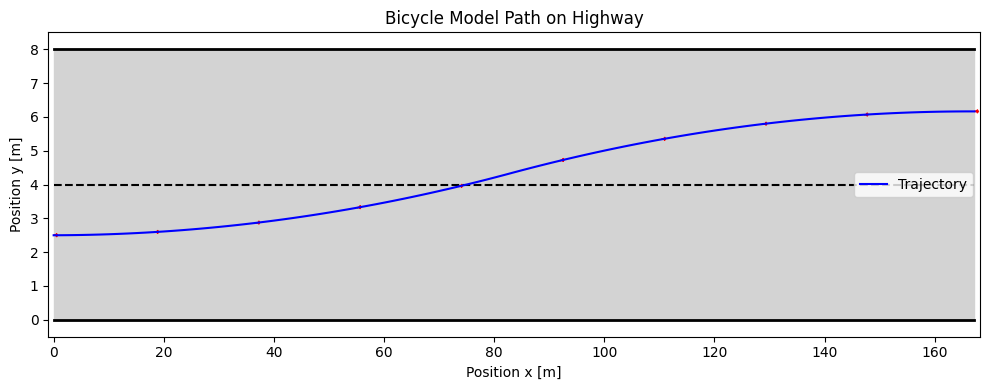

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Vehicle & model parameters (now lf = lr = 1.5 m)
lf, lr = 1.5, 1.5       

# 2. Simulation parameters
dt    = 0.05    # [s] time step
Nsim  = 100     # number of steps

# 3. Allocate state arrays: x, y, heading ψ, speed v
x   = np.zeros(Nsim+1)
y   = np.zeros(Nsim+1)
psi = np.zeros(Nsim+1)
v   = np.zeros(Nsim+1)

# 4. Initial condition: start at (0,1.5) m, heading=0, 120 km/h → m/s
x[0], y[0], psi[0] = 0.0, 2.5, 0.0
v[0] = 120/3.6

# 5. Piecewise‐constant inputs (acceleration, steering)
u1 = np.array([ 0.1,   5e-4 * np.pi])   # accelerate + slight right steer
u2 = np.array([-0.1,  -5e-4 * np.pi])   # decelerate + slight left steer
U  = np.vstack([u1]*(Nsim//2) + [u2]*(Nsim//2))

# 6. Euler integration of kinematic bicycle model
for k in range(Nsim):
    a_k, delta_k = U[k]
    beta   = np.arctan(lr/(lf+lr) * np.tan(delta_k))
    xdot   = v[k] * np.cos(psi[k] + beta)
    ydot   = v[k] * np.sin(psi[k] + beta)
    psidot = v[k]/lr * np.sin(beta)
    vdot   = a_k

    x[k+1]   = x[k]   + dt * xdot
    y[k+1]   = y[k]   + dt * ydot
    psi[k+1] = psi[k] + dt * psidot
    v[k+1]   = v[k]   + dt * vdot

# 7. Plotting: road from y=0 to y_max=8, dotted center at y=4
y_min, y_max = 0, 8

fig, ax = plt.subplots(figsize=(10,4))
# road fill & boundaries
ax.fill_between([x.min(), x.max()], y_min, y_max, color='lightgrey')
ax.plot([x.min(), x.max()], [y_min, y_min], 'k', lw=2)
ax.plot([x.min(), x.max()], [y_max, y_max], 'k', lw=2)

# dotted center line at y=4
ax.plot([x.min(), x.max()], [4, 4], linestyle='--', color='k')

# trajectory curve
ax.plot(x, y, 'b-', label='Trajectory')

# heading arrows at 10 evenly‐spaced points
for i in np.linspace(0, Nsim, 10, dtype=int):
    dx = np.cos(psi[i]) * 0.5
    dy = np.sin(psi[i]) * 0.5
    ax.arrow(x[i], y[i], dx, dy,
             head_width=0.1, head_length=0.2,
             fc='red', ec='red')

ax.set_xlabel('Position x [m]')
ax.set_ylabel('Position y [m]')
ax.set_title('Bicycle Model Path on Highway')
ax.set_xlim(x.min() - 1, x.max() + 1)
ax.set_ylim(y_min - 0.5, y_max + 0.5)
ax.legend()
plt.tight_layout()
plt.show()

Task 1

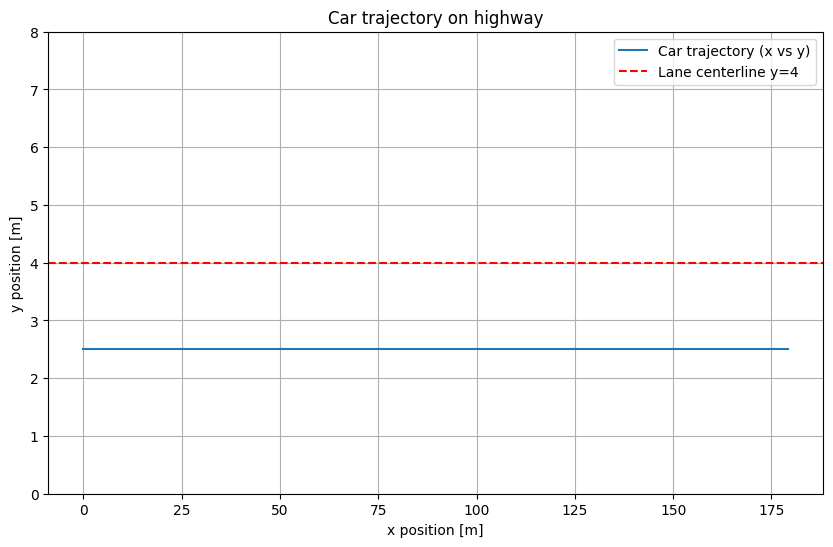

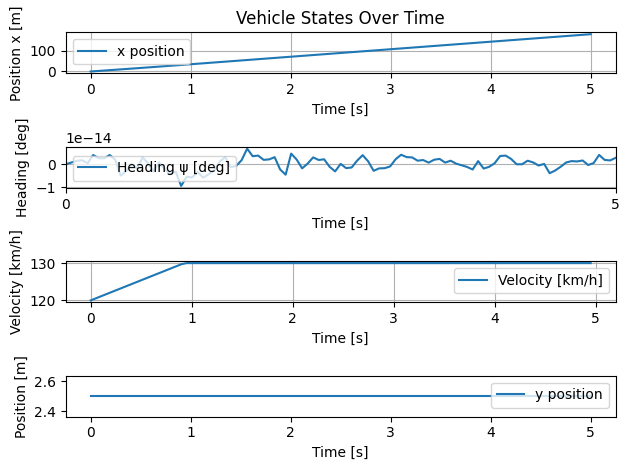

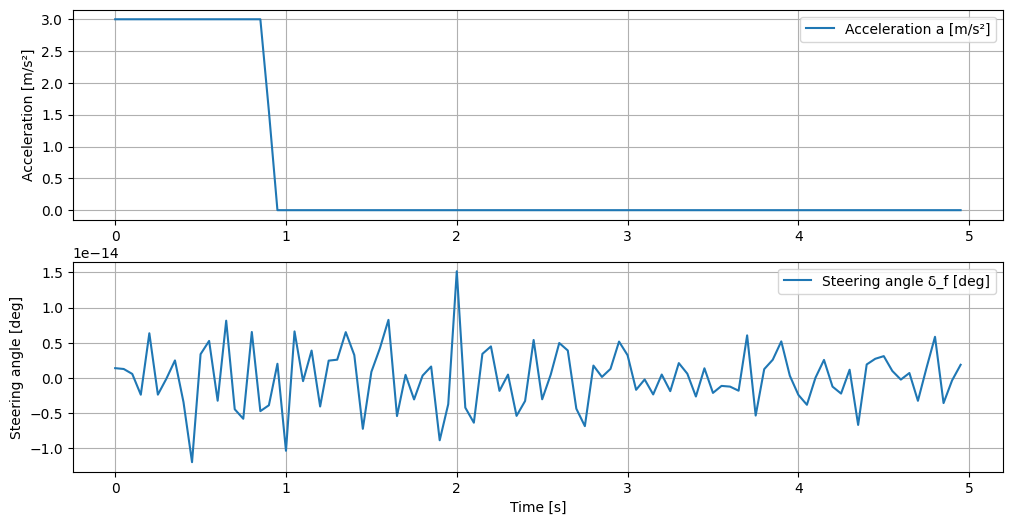

In [166]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# System parameters from the PDF
lf = 1.5     # distance from CoG to front axle
lr = 1.5     # distance from CoG to rear axle
lcar = lf + lr

# Sampling and prediction horizon
dt = 0.05     # sampling time (s)
N = 3         # prediction horizon
Nsim = 100    # simulation length in steps
d = 3         # collocation degree

# Bounds from the PDF (converted units)
psi_min = -np.pi / 2
psi_max = np.pi / 2
v_max = 130 / 3.6   # 130 km/h to m/s
a_min = -10
a_max = 3
delta_min = -np.pi/2
delta_max = np.pi/2

# Initial state (converted velocity)
x0_val = 0.0
y0_val = 2.5
psi0_val = 0.0
v0_val = 120 / 3.6   # 120 km/h to m/s

# Define CasADi symbols for states and controls
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)
n_states = states.size1()

a = ca.SX.sym('a')         # acceleration input
delta_f = ca.SX.sym('delta_f')  # steering input
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

# Slip angle beta
beta = ca.atan(lr/(lf + lr) * ca.tan(delta_f))

# Kinematic bicycle model dynamics (continuous time)
xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v / lr * ca.sin(beta)
vdot = a

rhs = ca.vertcat(xdot, ydot, psidot, vdot)

# Function for the system dynamics
f = ca.Function('f', [states, controls], [rhs])

# Collocation points (Legendre)
tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root  # include 0

# Coefficients for collocation equations
C = np.zeros((d+1, d+1))
D = np.zeros(d+1)
B = np.zeros(d+1)

# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation points
    L = 1
    for r in range(d+1):
        if r != j:
            L = np.poly1d(L) * np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    # Coefficients of the continuity equation
    D[j] = L(1.0)
    # Coefficients of the quadrature function
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    # Coefficients of the derivative of the polynomial at collocation points
    for r in range(d+1):
        C[j, r] = np.polyder(L)(tau_root[r])

# NLP variables
w = []          # decision variables vector
w0 = []         # initial guess
lbw = []        # lower bound for decision variables
ubw = []        # upper bound for decision variables
g = []          # constraints vector
lbg = []        # lower bound for constraints
ubg = []        # upper bound for constraints

# State and control bounds for NLP
state_min = [-ca.inf, -ca.inf, psi_min, 0.0]  # velocity >=0 assumed (no reverse)
state_max = [ca.inf, ca.inf, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

# Initial state parameter (will be updated in simulation)
Xk = ca.SX.sym('X0', n_states)
w += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0 += [x0_val, y0_val, psi0_val, v0_val]

# Objective function
J = 0

# For each step in horizon
for k in range(N):
    # Controls at step k
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w += [Uk]
    lbw += control_min
    ubw += control_max
    w0 += [0, 0]

    # States at collocation points within the interval k
    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w += [Xkj]
        lbw += state_min
        ubw += state_max
        w0 += [0, 0, 0, v0_val]

    # Loop over collocation points to form collocation equations
    # State at start of interval
    Xk_end = D[0] * Xk
    xdotk = 0

    for j in range(d):
        # Expression for the state derivative at collocation point
        xp = C[0, j+1] * Xk
        for r in range(d):
            xp += C[r+1, j+1] * Xc[r]

        fj = f(Xc[j], Uk)
        g += [dt * fj - xp]
        lbg += [0]*n_states
        ubg += [0]*n_states

        # Add contribution to the end state
        Xk_end += D[j+1] * Xc[j]

        # Accumulate for plotting or objective if needed
        # Here objective is time minimization => maximize velocity
        # We can minimize -v to maximize velocity over horizon
        # We sum over all collocation points weighted by B[j+1]
        J += -B[j+1] * Xc[j][3]  # index 3 is velocity v

    # Continuity equation: state at end of interval equals Xk_end
    Xk = ca.SX.sym(f'X_{k+1}', n_states)
    w += [Xk]
    lbw += state_min
    ubw += state_max
    w0 += [0, 0, 0, v0_val]

    g += [Xk - Xk_end]
    lbg += [0]*n_states
    ubg += [0]*n_states

# Setup NLP problem
prob = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}

# Solver options
opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.max_iter': 500, 'ipopt.tol': 1e-6}

solver = ca.nlpsol('solver', 'ipopt', prob, opts)

# Simulation variables
X_sim = np.zeros((Nsim+1, n_states))
U_sim = np.zeros((Nsim, n_controls))
t_sim = np.arange(Nsim+1) * dt

# Initialize simulation state
X_sim[0, :] = [x0_val, y0_val, psi0_val, v0_val]

# Initial guess vector for NLP variables
w0 = np.array(w0)

for sim_k in range(Nsim):
    # Set initial state bounds to current state
    lbw[:n_states] = X_sim[sim_k, :].tolist()
    ubw[:n_states] = X_sim[sim_k, :].tolist()

    # Solve NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    # Extract optimal control input U_0
    U_opt = w_opt[n_states:n_states+n_controls]
    U_sim[sim_k, :] = U_opt

    # Simulate one step forward with Euler integration
    f_value = f(X_sim[sim_k, :], U_opt).full().flatten()
    X_sim[sim_k+1, :] = X_sim[sim_k, :] + dt * f_value

    # Shift initial guess for warm start
    # Variables for states and controls are structured as:
    # [X0, U0, X0_c1, X0_c2, X0_c3, X1, U1, X1_c1, ..., XN]
    # We'll shift by one step horizon: remove first step, append zeros at end
    offset = n_states + n_controls + d*n_states  # size of one control interval block

    # Shift w0 accordingly: drop first block
    if (len(w0) - offset) > 0:
        w0 = np.concatenate([w_opt[offset:], np.zeros(offset)])
    else:
        w0 = np.array(w_opt)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(X_sim[:,0], X_sim[:,1], label='Car trajectory (x vs y)')
plt.ylim(0, 8)                     # Set y-axis limits from 0 to 8
plt.axhline(y=4, color='r', linestyle='--', label='Lane centerline y=4')  # Dotted line at y=4
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Car trajectory on highway')
plt.legend()
plt.grid(True)
plt.show()


plt.subplot(4,1,1)
plt.plot(t_sim, X_sim[:,0], label='x position')
plt.ylabel('Position x [m]')
plt.xlabel('Time [s]')
plt.title('Vehicle States Over Time')
plt.legend()
plt.grid()

plt.subplot(4,1,2)
plt.plot(t_sim, X_sim[:,2]*180/np.pi, label='Heading ψ [deg]')
plt.ylabel('Heading [deg]')
plt.xlabel('Time [s]')
plt.xticks(np.arange(0, Nsim*dt+1, 5))
plt.xlim(0, Nsim*dt)
plt.legend()
plt.grid()

plt.subplot(4,1,3)
plt.plot(t_sim[:-1], X_sim[:-1,3]*3.6, label='Velocity [km/h]')
plt.ylabel('Velocity [km/h]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.subplot(4,1,4)
plt.plot(t_sim, X_sim[:,1], label='y position')
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.plot(t_sim[:-1], U_sim[:,0], label='Acceleration a [m/s²]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t_sim[:-1], U_sim[:,1]*180/np.pi, label='Steering angle δ_f [deg]')
plt.ylabel('Steering angle [deg]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()



Task 2

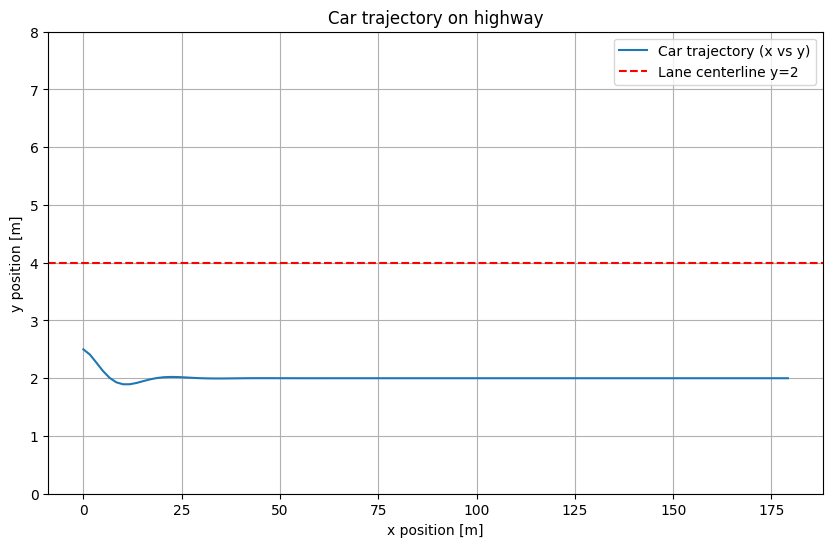

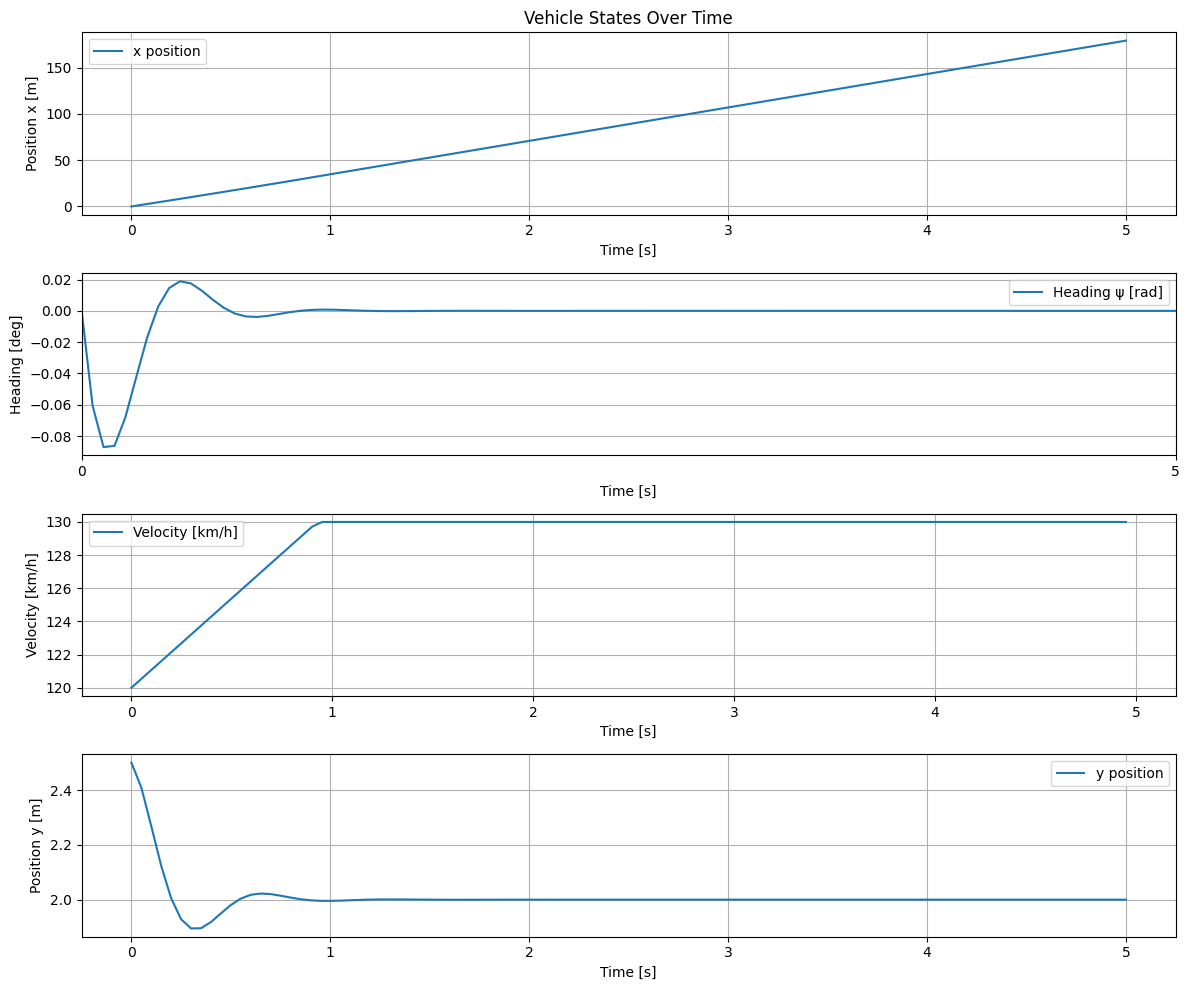

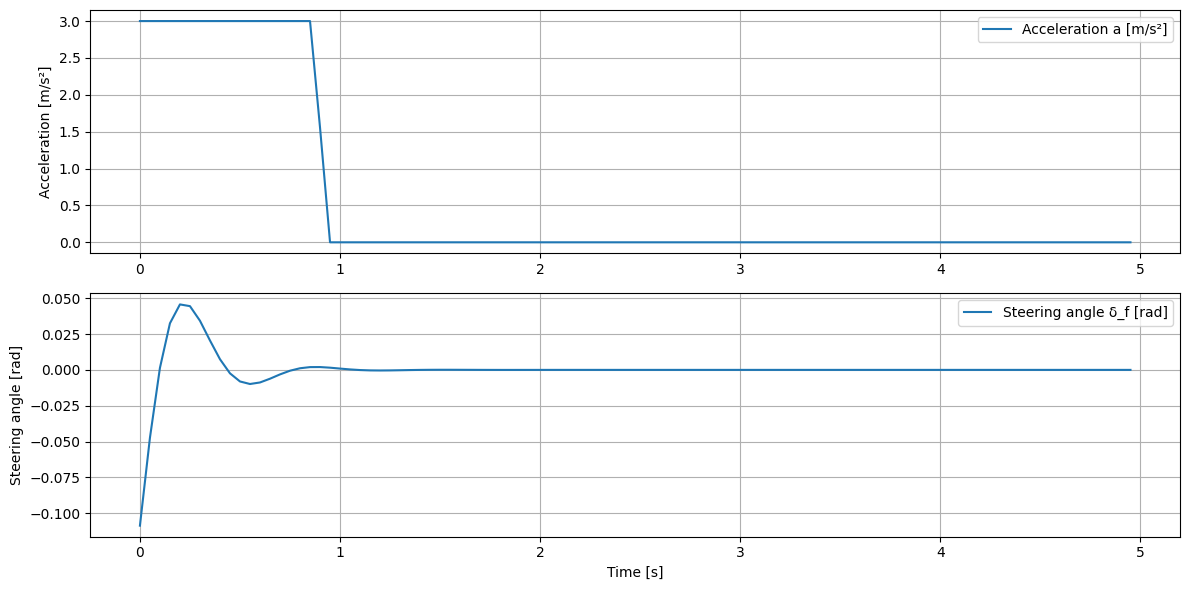

In [167]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# System parameters from the PDF
lf = 1.5
lr = 1.5
lcar = lf + lr

# Sampling and prediction horizon
dt = 0.05
N = 3
Nsim = 100
d = 3

# Bounds from the PDF (converted units)
psi_min = -np.pi / 2
psi_max = np.pi / 2
v_max = 130 / 3.6
a_min = -10
a_max = 3
delta_min = -np.pi / 2
delta_max = np.pi / 2

# Initial state (converted velocity)
x0_val = 0.0
y0_val = 2.5
psi0_val = 0.0
v0_val = 120 / 3.6

# CasADi symbols
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)
n_states = states.size1()

a = ca.SX.sym('a')
delta_f = ca.SX.sym('delta_f')
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

beta = ca.atan(lr / (lf + lr) * ca.tan(delta_f))

xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v / lr * ca.sin(beta)
vdot = a

rhs = ca.vertcat(xdot, ydot, psidot, vdot)
f = ca.Function('f', [states, controls], [rhs])

tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root

C = np.zeros((d + 1, d + 1))
D = np.zeros(d + 1)
B = np.zeros(d + 1)

for j in range(d + 1):
    L = 1
    for r in range(d + 1):
        if r != j:
            L = np.poly1d(L) * np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    for r in range(d + 1):
        C[j, r] = np.polyder(L)(tau_root[r])

w = []
w0 = []
lbw = []
ubw = []
g = []
lbg = []
ubg = []

# Lateral position constrained to lane boundaries
state_min = [-ca.inf, 0.0, psi_min, 0.0]
state_max = [ca.inf, 4.0, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

Xk = ca.SX.sym('X0', n_states)
w += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0 += [x0_val, y0_val, psi0_val, v0_val]

J = 0
w_y = 10     # weight for lateral position tracking
w_delta = 100  # weight for steering input penalty

for k in range(N):
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w += [Uk]
    lbw += control_min
    ubw += control_max
    w0 += [0, 0]

    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w += [Xkj]
        lbw += state_min
        ubw += state_max
        w0 += [0,0,0,v0_val]

    Xk_end = D[0] * Xk
    for j in range(d):
        xp = C[0, j + 1] * Xk
        for r in range(d):
            xp += C[r + 1, j + 1] * Xc[r]

        fj = f(Xc[j], Uk)
        g += [dt * fj - xp]
        lbg += [0] * n_states
        ubg += [0] * n_states

        Xk_end += D[j + 1] * Xc[j]

        # Objective: maximize velocity, track y=2, penalize steering input magnitude
        J += -B[j + 1] * Xc[j][3] + w_y * B[j + 1] * (Xc[j][1] - 2) ** 2 + w_delta * B[j + 1] * Uk[1] ** 2

    Xk = ca.SX.sym(f'X_{k + 1}', n_states)
    w += [Xk]
    lbw += state_min
    ubw += state_max
    w0 += [0, 0, 0, v0_val]

    g += [Xk - Xk_end]
    lbg += [0] * n_states
    ubg += [0] * n_states

prob = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}

opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.max_iter': 500, 'ipopt.tol': 1e-6}

solver = ca.nlpsol('solver', 'ipopt', prob, opts)

X_sim = np.zeros((Nsim + 1, n_states))
U_sim = np.zeros((Nsim, n_controls))
t_sim = np.arange(Nsim + 1) * dt

X_sim[0, :] = [x0_val, y0_val, psi0_val, v0_val]

w0 = np.array(w0)

for sim_k in range(Nsim):
    lbw[:n_states] = X_sim[sim_k, :].tolist()
    ubw[:n_states] = X_sim[sim_k, :].tolist()

    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    U_opt = w_opt[n_states:n_states + n_controls]
    U_sim[sim_k, :] = U_opt

    f_value = f(X_sim[sim_k, :], U_opt).full().flatten()
    X_sim[sim_k + 1, :] = X_sim[sim_k, :] + dt * f_value

    offset = n_states + n_controls + d * n_states
    if (len(w0) - offset) > 0:
        w0 = np.concatenate([w_opt[offset:], np.zeros(offset)])
    else:
        w0 = np.array(w_opt)

plt.figure(figsize=(10, 6))
plt.plot(X_sim[:, 0], X_sim[:, 1], label='Car trajectory (x vs y)')
plt.ylim(0, 8)
plt.axhline(y=4, color='r', linestyle='--', label='Lane centerline y=2')
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Car trajectory on highway')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t_sim, X_sim[:, 0], label='x position')
plt.ylabel('Position x [m]')
plt.xlabel('Time [s]')
plt.title('Vehicle States Over Time')
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(t_sim, X_sim[:, 2] , label='Heading ψ [rad]')
plt.ylabel('Heading [deg]')
plt.xlabel('Time [s]')
plt.xticks(np.arange(0, Nsim * dt + 1, 5))
plt.xlim(0, Nsim * dt)
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t_sim[:-1], X_sim[:-1, 3] * 3.6, label='Velocity [km/h]')
plt.ylabel('Velocity [km/h]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t_sim, X_sim[:, 1], label='y position')
plt.ylabel('Position y [m]')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sim[:-1], U_sim[:, 0], label='Acceleration a [m/s²]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_sim[:-1], U_sim[:, 1], label='Steering angle δ_f [rad]')
plt.ylabel('Steering angle [rad]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Task 3

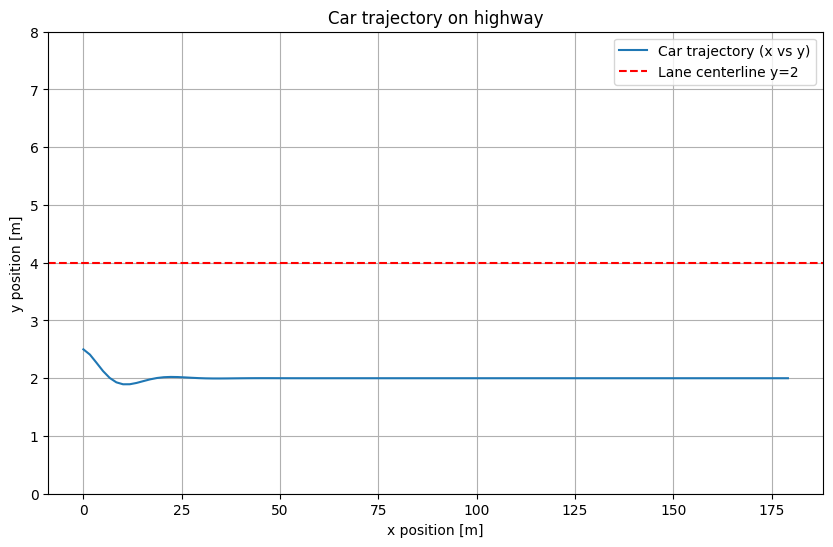

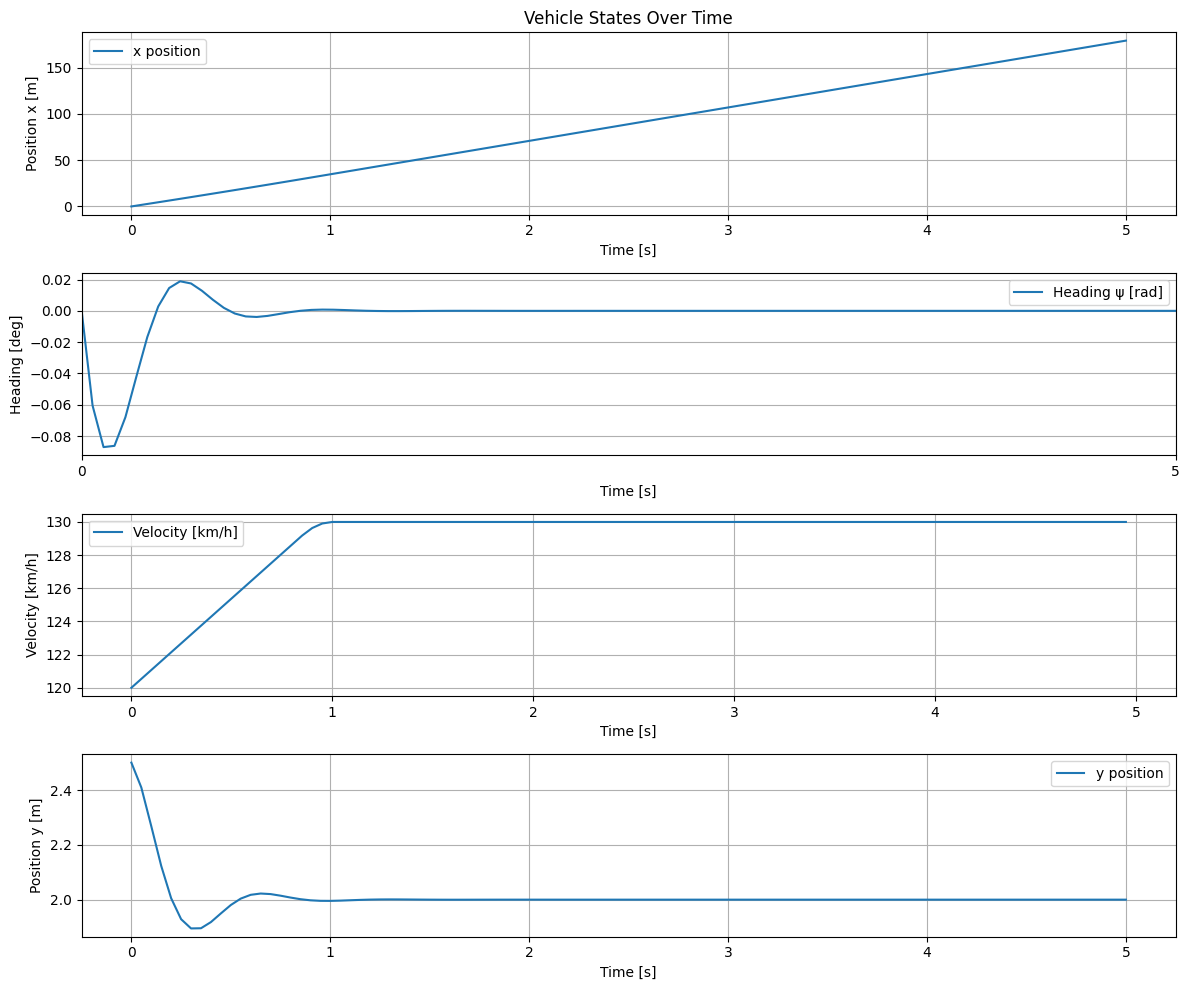

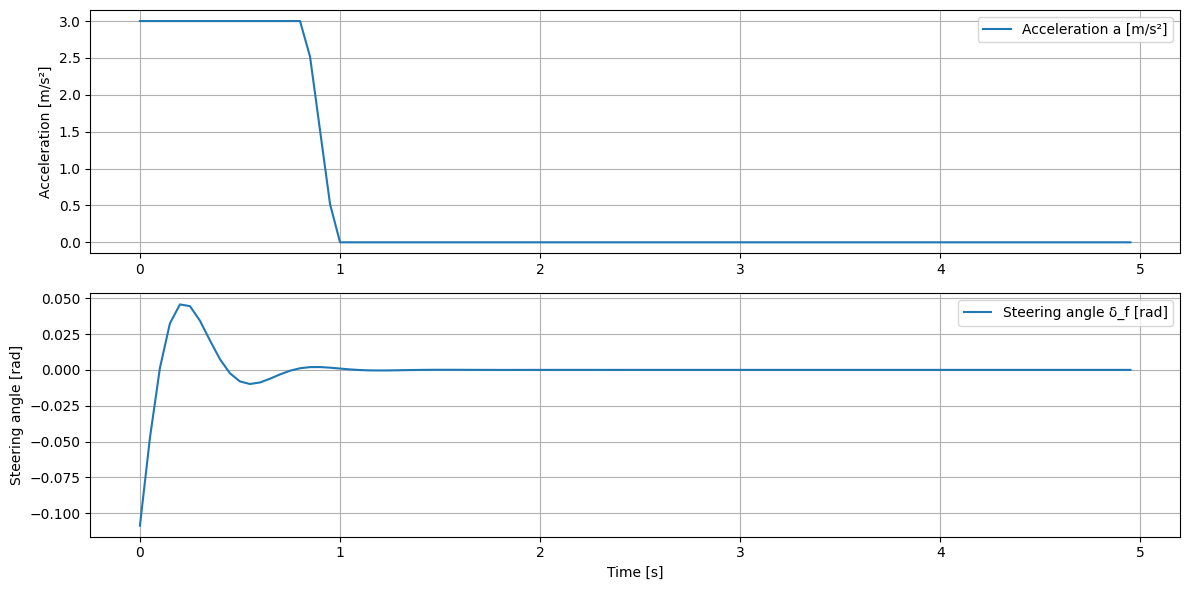

In [173]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lf = 1.5
lr = 1.5
lcar = lf + lr

dt = 0.05
N = 3
Nsim = 100
d = 3

psi_min = -np.pi / 2
psi_max = np.pi / 2
v_max = 130 / 3.6
a_min = -10
a_max = 3
delta_min = -np.pi / 2
delta_max = np.pi / 2

x0_val = 0.0
y0_val = 2.5
psi0_val = 0.0
v0_val = 120 / 3.6

# Input rate limits
delta_u_max = np.array([1.0, np.pi / 20])  # max input change per step

# CasADi symbols
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)
n_states = states.size1()

a = ca.SX.sym('a')
delta_f = ca.SX.sym('delta_f')
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

beta = ca.atan(lr / (lf + lr) * ca.tan(delta_f))

xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v / lr * ca.sin(beta)
vdot = a

rhs = ca.vertcat(xdot, ydot, psidot, vdot)
f = ca.Function('f', [states, controls], [rhs])

tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root

C = np.zeros((d + 1, d + 1))
D = np.zeros(d + 1)
B = np.zeros(d + 1)

for j in range(d + 1):
    L = 1
    for r in range(d + 1):
        if r != j:
            L = np.poly1d(L) * np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    for r in range(d + 1):
        C[j, r] = np.polyder(L)(tau_root[r])

# NLP variables
w = []
w0 = []
lbw = []
ubw = []
g = []
lbg = []
ubg = []

state_min = [-ca.inf, 0.0, psi_min, 0.0]
state_max = [ca.inf, 4.0, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

Xk = ca.SX.sym('X0', n_states)
w += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0 += [x0_val, y0_val, psi0_val, v0_val]

J = 0
w_y = 10
w_delta = 100

# To store control vars for input rate constraints
U_prev = None

for k in range(N):
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w += [Uk]
    lbw += control_min
    ubw += control_max
    w0 += [0, 0]

    if k > 0:
        # Add input rate constraints: -delta_u_max <= Uk - U_prev <= delta_u_max
        g += [Uk - U_prev]
        lbg += [ -val for val in delta_u_max.tolist() ]
        ubg += delta_u_max.tolist()

    U_prev = Uk

    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w += [Xkj]
        lbw += state_min
        ubw += state_max
        w0 += [0, 0, 0, v0_val]

    Xk_end = D[0] * Xk
    for j in range(d):
        xp = C[0, j + 1] * Xk
        for r in range(d):
            xp += C[r + 1, j + 1] * Xc[r]

        fj = f(Xc[j], Uk)
        g += [dt * fj - xp]
        lbg += [0] * n_states
        ubg += [0] * n_states

        Xk_end += D[j + 1] * Xc[j]

        J += -B[j + 1] * Xc[j][3] + w_y * B[j + 1] * (Xc[j][1] - 2) ** 2 + w_delta * B[j + 1] * Uk[1] ** 2

    Xk = ca.SX.sym(f'X_{k + 1}', n_states)
    w += [Xk]
    lbw += state_min
    ubw += state_max
    w0 += [0, 0, 0, v0_val]

    g += [Xk - Xk_end]
    lbg += [0] * n_states
    ubg += [0] * n_states

prob = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}

opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.max_iter': 500, 'ipopt.tol': 1e-6}

solver = ca.nlpsol('solver', 'ipopt', prob, opts)

X_sim = np.zeros((Nsim + 1, n_states))
U_sim = np.zeros((Nsim, n_controls))
t_sim = np.arange(Nsim + 1) * dt

X_sim[0, :] = [x0_val, y0_val, psi0_val, v0_val]

w0 = np.array(w0)

# Store previous control input for input rate at simulation level
u_prev_sim = np.array([0.0, 0.0])

for sim_k in range(Nsim):
    lbw[:n_states] = X_sim[sim_k, :].tolist()
    ubw[:n_states] = X_sim[sim_k, :].tolist()

    # Provide previous control input to first control variable for input rate constraints
    # (Shift NLP variables accordingly in a real implementation)
    # Here, approximate by adding a constraint at k=0 comparing with u_prev_sim
    # (If needed, add parameter to NLP formulation for initial previous control)

    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    U_opt = w_opt[n_states:n_states + n_controls]
    U_sim[sim_k, :] = U_opt

    f_value = f(X_sim[sim_k, :], U_opt).full().flatten()
    X_sim[sim_k + 1, :] = X_sim[sim_k, :] + dt * f_value

    offset = n_states + n_controls + d * n_states
    if (len(w0) - offset) > 0:
        w0 = np.concatenate([w_opt[offset:], np.zeros(offset)])
    else:
        w0 = np.array(w_opt)

    u_prev_sim = U_opt  # update previous control

plt.figure(figsize=(10, 6))
plt.plot(X_sim[:, 0], X_sim[:, 1], label='Car trajectory (x vs y)')
plt.ylim(0, 8)
plt.axhline(y=4, color='r', linestyle='--', label='Lane centerline y=2')
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Car trajectory on highway')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t_sim, X_sim[:, 0], label='x position')
plt.ylabel('Position x [m]')
plt.xlabel('Time [s]')
plt.title('Vehicle States Over Time')
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(t_sim, X_sim[:, 2] , label='Heading ψ [rad]')
plt.ylabel('Heading [deg]')
plt.xlabel('Time [s]')
plt.xticks(np.arange(0, Nsim * dt + 1, 5))
plt.xlim(0, Nsim * dt)
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t_sim[:-1], X_sim[:-1, 3] * 3.6, label='Velocity [km/h]')
plt.ylabel('Velocity [km/h]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t_sim, X_sim[:, 1], label='y position')
plt.ylabel('Position y [m]')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sim[:-1], U_sim[:, 0], label='Acceleration a [m/s²]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_sim[:-1], U_sim[:, 1], label='Steering angle δ_f [rad]')
plt.ylabel('Steering angle [rad]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Task 4 With N=3

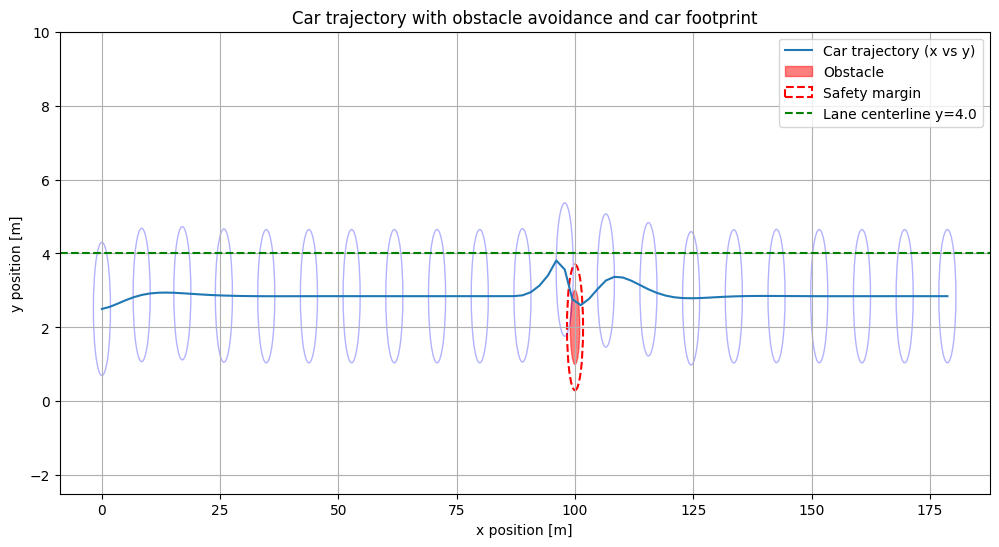

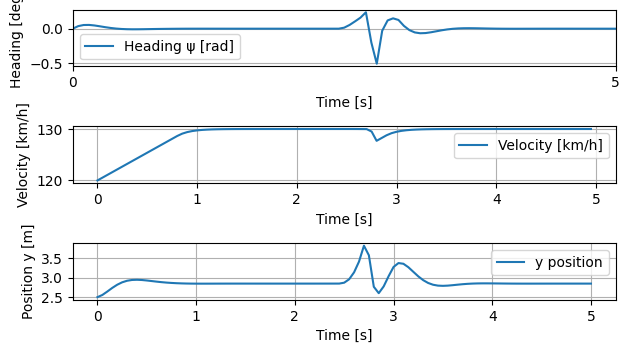

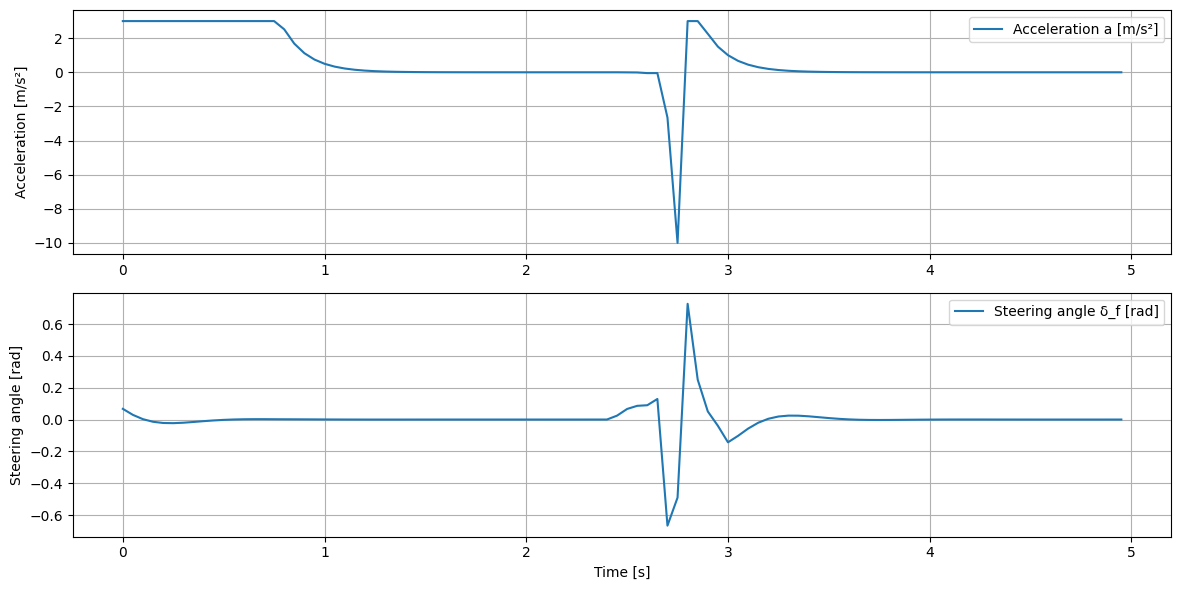

In [27]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# System parameters
lf = 1.5
lr = 1.5
car_length = 3.0
car_width = 2.0
r_car = np.sqrt(car_length**2 + car_width**2) / 2  # ~1.802 m

# Lane parameters
lane_center = 4.0
lane_width = 8.0
y_min = 0.0
y_max = 8- r_car  # ~5.202 m
# Obstacle parameters
obs_x = 100.0
obs_y = 2.0
r_obs = 1.0
obs_margin = 1.7  # increased margin
safe_dist = r_obs + r_car + obs_margin

# Sampling and prediction horizon
dt = 0.05
N = 3 # increased horizon
Nsim = 100
d = 3

# Bounds
psi_min = -np.pi / 2
psi_max = np.pi / 2
v_max = 130 / 3.6
a_min = -10
a_max = 3
delta_min = -np.pi / 2
delta_max = 0.5*np.pi / 2

# Initial state
x0_val = 0.0
y0_val = 2.5
psi0_val = 0.0
v0_val = 120 / 3.6

# Input rate limits for smooth control
delta_u_max = np.array([1.0, np.pi / 20])  # max changes per step (acceleration, steering)

# CasADi symbols
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)
n_states = states.size1()

a = ca.SX.sym('a')
delta_f = ca.SX.sym('delta_f')
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

beta = ca.atan(lr / (lf + lr) * ca.tan(delta_f))

xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v / lr * ca.sin(beta)
vdot = a

rhs = ca.vertcat(xdot, ydot, psidot, vdot)
f = ca.Function('f', [states, controls], [rhs])

tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root

C = np.zeros((d + 1, d + 1))
D = np.zeros(d + 1)
B = np.zeros(d + 1)

for j in range(d + 1):
    L = 1
    for r in range(d + 1):
        if r != j:
            L = np.poly1d(L) * np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    for r in range(d + 1):
        C[j, r] = np.polyder(L)(tau_root[r])

w = []
w0 = []
lbw = []
ubw = []
g = []
lbg = []
ubg = []

state_min = [-ca.inf, y_min, psi_min, 0.0]
state_max = [ca.inf, y_max, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

Xk = ca.SX.sym('X0', n_states)
w += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0 += [x0_val, y0_val, psi0_val, v0_val]

J = 0
w_y = 20      # reduced lateral penalty weight
w_delta = 20  # reduced steering penalty weight
w_obs = 1000  # obstacle soft penalty weight
w_acc_rate = 100
w_steer_rate = 50

U_prev = None  # for input rate constraints

for k in range(N):
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w += [Uk]
    lbw += control_min
    ubw += control_max
    w0 += [0, 0]

    # Input rate constraints
    if U_prev is not None:
        g.append(Uk - U_prev)
        lbg.extend((-delta_u_max).tolist())
        ubg.extend(delta_u_max.tolist())
        J += w_acc_rate * ca.sumsqr(Uk[0] - U_prev[0])
        J += w_steer_rate * (Uk[1] - U_prev[1])**2
    U_prev = Uk

    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w += [Xkj]
        lbw += state_min
        ubw += state_max
        w0 += [0, 0, 0, v0_val]

    Xk_end = D[0] * Xk
    for j in range(d):
        xp = C[0, j + 1] * Xk
        for r in range(d):
            xp += C[r + 1, j + 1] * Xc[r]

        fj = f(Xc[j], Uk)
        g += [dt * fj - xp]
        lbg += [0] * n_states
        ubg += [0] * n_states

        Xk_end += D[j + 1] * Xc[j]

        dx = Xc[j][0] - obs_x
        dy = Xc[j][1] - obs_y
        dist_sq = dx**2 + dy**2

        # Smooth transition for lateral penalty: reduce near obstacle
        weight_factor = ca.if_else(dist_sq < (safe_dist + 5)**2, 0.1, 1.0)

        J += (-0.5*B[j + 1] * Xc[j][3] +
              weight_factor * w_y * B[j + 1] * (Xc[j][1] - 2)**2 +
              w_delta * B[j + 1] * Uk[1]**2 +
              w_obs * B[j + 1]/ dist_sq)

    Xk = ca.SX.sym(f'X_{k + 1}', n_states)
    w += [Xk]
    lbw += state_min
    ubw += state_max
    w0 += [0, 0, 0, v0_val]

    g += [Xk - Xk_end]
    lbg += [0] * n_states
    ubg += [0] * n_states

# Terminal cost on lateral position y and velocity v
W_terminal = ca.diag(ca.vertcat(0, 100, 0, 100))
x_ref_terminal = ca.DM([0, lane_center, 0, v_max])
diff = Xk - x_ref_terminal
J += ca.mtimes([diff.T, W_terminal, diff])

prob = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}

opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.max_iter': 2000, 'ipopt.tol': 1e-6}

solver = ca.nlpsol('solver', 'ipopt', prob, opts)

X_sim = np.zeros((Nsim + 1, n_states))
U_sim = np.zeros((Nsim, n_controls))
t_sim = np.arange(Nsim + 1) * dt

X_sim[0, :] = [x0_val, y0_val, psi0_val, v0_val]

w0 = np.array(w0)

for sim_k in range(Nsim):
    lbw[:n_states] = X_sim[sim_k, :].tolist()
    ubw[:n_states] = X_sim[sim_k, :].tolist()

    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    U_opt = w_opt[n_states:n_states + n_controls]
    U_sim[sim_k, :] = U_opt

    f_value = f(X_sim[sim_k, :], U_opt).full().flatten()
    X_sim[sim_k + 1, :] = X_sim[sim_k, :] + dt * f_value

    offset = n_states + n_controls + d * n_states
    if (len(w0) - offset) > 0:
        w0 = np.concatenate([w_opt[offset:], np.zeros(offset)])
    else:
        w0 = np.array(w_opt)

plt.figure(figsize=(12, 6))
plt.plot(X_sim[:, 0], X_sim[:, 1], label='Car trajectory (x vs y)')

# Plot obstacle filled circle
circle_obs = plt.Circle((obs_x, obs_y), r_obs, color='r', alpha=0.5, label='Obstacle')
plt.gca().add_patch(circle_obs)

# Plot safety margin circle as dotted line
circle_margin = plt.Circle((obs_x, obs_y), obs_margin, color='r', fill=False, linestyle='--', linewidth=1.5, label='Safety margin')
plt.gca().add_patch(circle_margin)

# Lane centerline
plt.axhline(y=lane_center, color='g', linestyle='--', label=f'Lane centerline y={lane_center}')

# Plot car radius circles at selected timestamps (to avoid clutter, plot every nth circle)
n_plot = 5  # plot every 10th position
for i in range(0, len(X_sim), n_plot):
    circle_car = plt.Circle((X_sim[i, 0], X_sim[i, 1]), r_car, color='b', fill=False, alpha=0.3)
    plt.gca().add_patch(circle_car)

plt.ylim(-2.5,10)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Car trajectory with obstacle avoidance and car footprint')
plt.legend()
plt.grid(True)
plt.show()



plt.subplot(4, 1, 2)
plt.plot(t_sim, X_sim[:, 2], label='Heading ψ [rad]')
plt.ylabel('Heading [deg]')
plt.xlabel('Time [s]')
plt.xticks(np.arange(0, Nsim * dt + 1, 5))
plt.xlim(0, Nsim * dt)
plt.legend()
plt.grid()


plt.subplot(4, 1, 3)
plt.plot(t_sim[:-1], X_sim[:-1, 3] * 3.6, label='Velocity [km/h]')
plt.ylabel('Velocity [km/h]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t_sim, X_sim[:, 1], label='y position')
plt.ylabel('Position y [m]')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sim[:-1], U_sim[:, 0], label='Acceleration a [m/s²]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_sim[:-1], U_sim[:, 1], label='Steering angle δ_f [rad]')
plt.ylabel('Steering angle [rad]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Task 4 with Increasing N=10

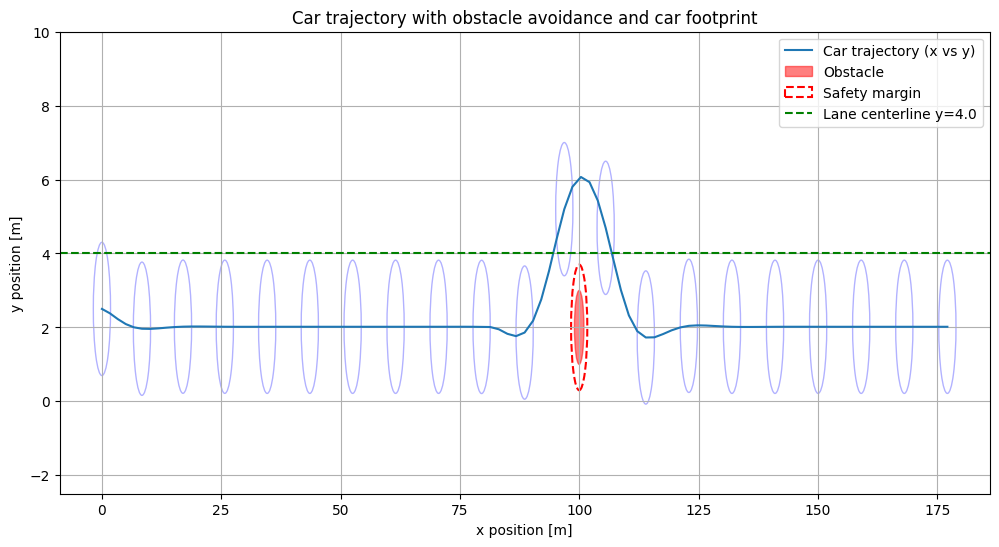

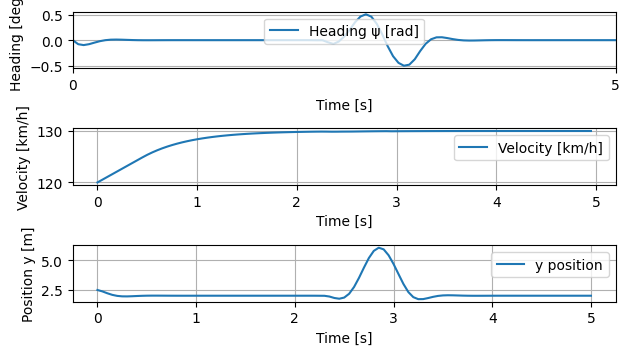

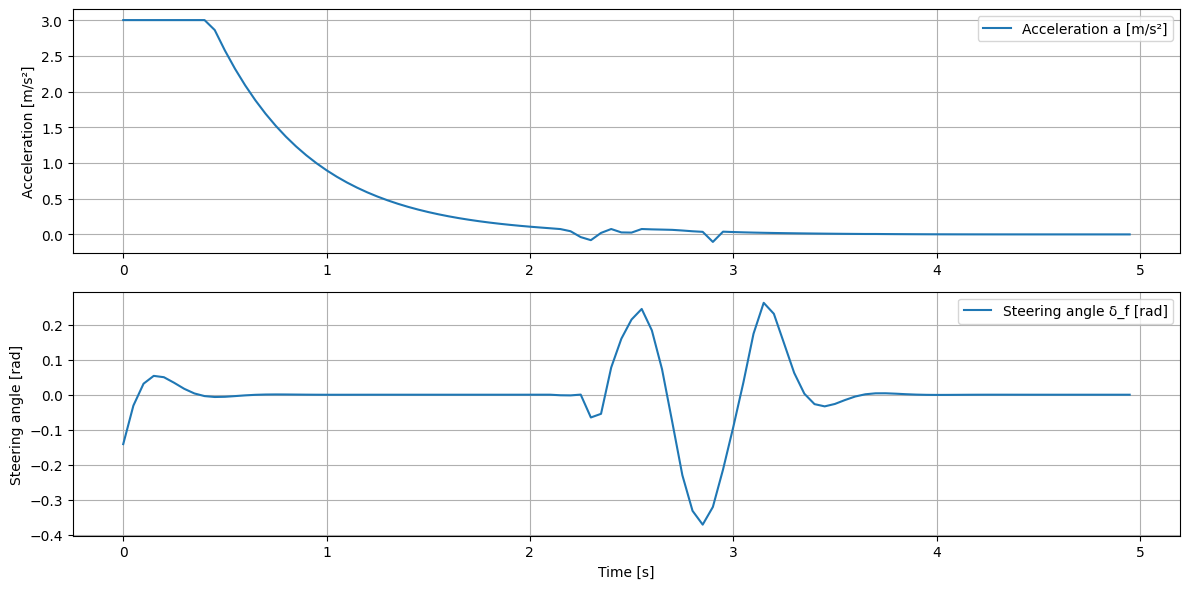

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# System parameters
lf = 1.5
lr = 1.5
car_length = 3.0
car_width = 2.0
r_car = np.sqrt(car_length**2 + car_width**2) / 2  # ~1.802 m

# Lane parameters
lane_center = 4.0
lane_width = 8.0
y_min = 0.0
y_max = 8- r_car  # ~5.202 m
# Obstacle parameters
obs_x = 100.0
obs_y = 2.0
r_obs = 1.0
obs_margin = 1.7  # increased margin
safe_dist = r_obs + r_car + obs_margin

# Sampling and prediction horizon
dt = 0.05
N = 10 # increased horizon
Nsim = 100
d = 3

# Bounds
psi_min = -np.pi / 2
psi_max = np.pi / 2
v_max = 130 / 3.6
a_min = -10
a_max = 3
delta_min = -np.pi / 2
delta_max = 0.5*np.pi / 2

# Initial state
x0_val = 0.0
y0_val = 2.5
psi0_val = 0.0
v0_val = 120 / 3.6

# Input rate limits for smooth control
delta_u_max = np.array([1.0, np.pi / 20])  # max changes per step (acceleration, steering)

# CasADi symbols
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)
n_states = states.size1()

a = ca.SX.sym('a')
delta_f = ca.SX.sym('delta_f')
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

beta = ca.atan(lr / (lf + lr) * ca.tan(delta_f))

xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v / lr * ca.sin(beta)
vdot = a

rhs = ca.vertcat(xdot, ydot, psidot, vdot)
f = ca.Function('f', [states, controls], [rhs])

tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root

C = np.zeros((d + 1, d + 1))
D = np.zeros(d + 1)
B = np.zeros(d + 1)

for j in range(d + 1):
    L = 1
    for r in range(d + 1):
        if r != j:
            L = np.poly1d(L) * np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    for r in range(d + 1):
        C[j, r] = np.polyder(L)(tau_root[r])

w = []
w0 = []
lbw = []
ubw = []
g = []
lbg = []
ubg = []

state_min = [-ca.inf, y_min, psi_min, 0.0]
state_max = [ca.inf, y_max, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

Xk = ca.SX.sym('X0', n_states)
w += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0 += [x0_val, y0_val, psi0_val, v0_val]

J = 0
w_y = 20      # reduced lateral penalty weight
w_delta = 20  # reduced steering penalty weight
w_obs = 1000  # obstacle soft penalty weight
w_acc_rate = 100
w_steer_rate = 50

U_prev = None  # for input rate constraints

for k in range(N):
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w += [Uk]
    lbw += control_min
    ubw += control_max
    w0 += [0, 0]

    # Input rate constraints
    if U_prev is not None:
        g.append(Uk - U_prev)
        lbg.extend((-delta_u_max).tolist())
        ubg.extend(delta_u_max.tolist())
        J += w_acc_rate * ca.sumsqr(Uk[0] - U_prev[0])
        J += w_steer_rate * (Uk[1] - U_prev[1])**2
    U_prev = Uk

    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w += [Xkj]
        lbw += state_min
        ubw += state_max
        w0 += [0, 0, 0, v0_val]

    Xk_end = D[0] * Xk
    for j in range(d):
        xp = C[0, j + 1] * Xk
        for r in range(d):
            xp += C[r + 1, j + 1] * Xc[r]

        fj = f(Xc[j], Uk)
        g += [dt * fj - xp]
        lbg += [0] * n_states
        ubg += [0] * n_states

        Xk_end += D[j + 1] * Xc[j]

        dx = Xc[j][0] - obs_x
        dy = Xc[j][1] - obs_y
        dist_sq = dx**2 + dy**2

        # Smooth transition for lateral penalty: reduce near obstacle
        weight_factor = ca.if_else(dist_sq < (safe_dist + 5)**2, 0.1, 1.0)

        J += (-0.5*B[j + 1] * Xc[j][3] +
              weight_factor * w_y * B[j + 1] * (Xc[j][1] - 2)**2 +
              w_delta * B[j + 1] * Uk[1]**2 +
              w_obs * B[j + 1]/ dist_sq)

    Xk = ca.SX.sym(f'X_{k + 1}', n_states)
    w += [Xk]
    lbw += state_min
    ubw += state_max
    w0 += [0, 0, 0, v0_val]

    g += [Xk - Xk_end]
    lbg += [0] * n_states
    ubg += [0] * n_states

# Terminal cost on lateral position y and velocity v
W_terminal = ca.diag(ca.vertcat(0, 100, 0, 100))
x_ref_terminal = ca.DM([0, lane_center, 0, v_max])
diff = Xk - x_ref_terminal
J += ca.mtimes([diff.T, W_terminal, diff])

prob = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}

opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.max_iter': 2000, 'ipopt.tol': 1e-6}

solver = ca.nlpsol('solver', 'ipopt', prob, opts)

X_sim = np.zeros((Nsim + 1, n_states))
U_sim = np.zeros((Nsim, n_controls))
t_sim = np.arange(Nsim + 1) * dt

X_sim[0, :] = [x0_val, y0_val, psi0_val, v0_val]

w0 = np.array(w0)

for sim_k in range(Nsim):
    lbw[:n_states] = X_sim[sim_k, :].tolist()
    ubw[:n_states] = X_sim[sim_k, :].tolist()

    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    U_opt = w_opt[n_states:n_states + n_controls]
    U_sim[sim_k, :] = U_opt

    f_value = f(X_sim[sim_k, :], U_opt).full().flatten()
    X_sim[sim_k + 1, :] = X_sim[sim_k, :] + dt * f_value

    offset = n_states + n_controls + d * n_states
    if (len(w0) - offset) > 0:
        w0 = np.concatenate([w_opt[offset:], np.zeros(offset)])
    else:
        w0 = np.array(w_opt)

plt.figure(figsize=(12, 6))
plt.plot(X_sim[:, 0], X_sim[:, 1], label='Car trajectory (x vs y)')

# Plot obstacle filled circle
circle_obs = plt.Circle((obs_x, obs_y), r_obs, color='r', alpha=0.5, label='Obstacle')
plt.gca().add_patch(circle_obs)

# Plot safety margin circle as dotted line
circle_margin = plt.Circle((obs_x, obs_y), obs_margin, color='r', fill=False, linestyle='--', linewidth=1.5, label='Safety margin')
plt.gca().add_patch(circle_margin)

# Lane centerline
plt.axhline(y=lane_center, color='g', linestyle='--', label=f'Lane centerline y={lane_center}')

# Plot car radius circles at selected timestamps (to avoid clutter, plot every nth circle)
n_plot = 5  # plot every 10th position
for i in range(0, len(X_sim), n_plot):
    circle_car = plt.Circle((X_sim[i, 0], X_sim[i, 1]), r_car, color='b', fill=False, alpha=0.3)
    plt.gca().add_patch(circle_car)

plt.ylim(-2.5,10)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Car trajectory with obstacle avoidance and car footprint')
plt.legend()
plt.grid(True)
plt.show()



plt.subplot(4, 1, 2)
plt.plot(t_sim, X_sim[:, 2], label='Heading ψ [rad]')
plt.ylabel('Heading [deg]')
plt.xlabel('Time [s]')
plt.xticks(np.arange(0, Nsim * dt + 1, 5))
plt.xlim(0, Nsim * dt)
plt.legend()
plt.grid()


plt.subplot(4, 1, 3)
plt.plot(t_sim[:-1], X_sim[:-1, 3] * 3.6, label='Velocity [km/h]')
plt.ylabel('Velocity [km/h]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t_sim, X_sim[:, 1], label='y position')
plt.ylabel('Position y [m]')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sim[:-1], U_sim[:, 0], label='Acceleration a [m/s²]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_sim[:-1], U_sim[:, 1], label='Steering angle δ_f [rad]')
plt.ylabel('Steering angle [rad]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Additional Task :Multiple Obstacle Avoidance

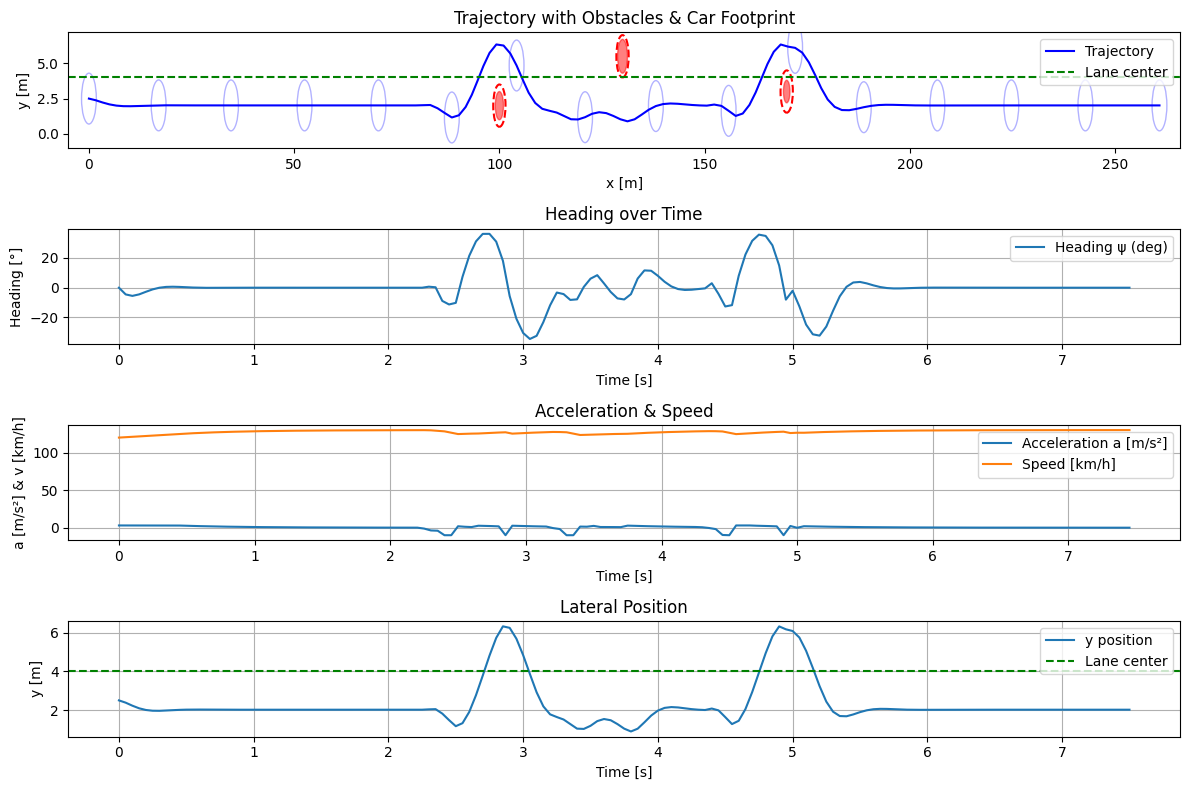

In [26]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# === Vehicle & lane parameters ===
lf = 1.5
lr = 1.5
car_length = lf + lr
car_width = 2.0
r_car = np.sqrt(car_length**2 + car_width**2) / 2

lane_center = 4.0
y_min = 0.0
y_max = 8.0 - r_car

# === Obstacles: list of (x, y, radius) ===
obstacles = [
    (100.0, 2.0, 1.0),
    (130.0, 5.5, 1.2),
    (170.0, 3.0, 0.8),
    # add more tuples here as needed
]
obs_margin = 1.5   # safety margin

# === MPC & simulation parameters ===
dt     = 0.05
N      = 10       # prediction horizon
Nsim   = 150
d      = 3        # collocation degree

# State & control bounds
psi_min, psi_max = -np.pi/2, np.pi/2
v_max           = 130/3.6
a_min, a_max    = -10, 3
delta_min       = -np.pi/2
delta_max       = 0.5*np.pi/2

# Input rate limits (for smoothing)
delta_u_max = np.array([1.0, np.pi/20])

# Initial condition
x0_val, y0_val = 0.0, 2.5
psi0_val       = 0.0
v0_val         = 120/3.6

# === CasADi model setup ===
x    = ca.SX.sym('x'); y    = ca.SX.sym('y')
psi  = ca.SX.sym('psi'); v  = ca.SX.sym('v')
states  = ca.vertcat(x, y, psi, v)
n_states  = states.size1()

a      = ca.SX.sym('a'); delta_f = ca.SX.sym('delta_f')
controls = ca.vertcat(a, delta_f)
n_controls = controls.size1()

beta = ca.atan(lr/(lf+lr) * ca.tan(delta_f))
xdot = v * ca.cos(psi + beta)
ydot = v * ca.sin(psi + beta)
psidot = v/ lr * ca.sin(beta)
vdot = a
rhs = ca.vertcat(xdot, ydot, psidot, vdot)
f   = ca.Function('f', [states, controls], [rhs])

# Collocation coefficients
tau_root = ca.collocation_points(d, 'legendre')
tau_root = [0] + tau_root
C = np.zeros((d+1, d+1)); D = np.zeros(d+1); B = np.zeros(d+1)
for j in range(d+1):
    L = 1
    for r in range(d+1):
        if r!=j:
            L = np.poly1d(L)*np.poly1d([1, -tau_root[r]])/(tau_root[j]-tau_root[r])
    D[j] = L(1.0)
    p_int = np.polyint(L)
    B[j] = p_int(1.0)
    for r in range(d+1):
        C[j,r] = np.polyder(L)(tau_root[r])

# === NLP variable containers ===
w, w0, lbw, ubw = [], [], [], []
g, lbg, ubg      = [], [], []

# State & control bounds arrays
state_min = [-ca.inf, y_min, psi_min, 0.0]
state_max = [ ca.inf, y_max, psi_max, v_max]
control_min = [a_min, delta_min]
control_max = [a_max, delta_max]

# === NLP initial state parameter ===
Xk = ca.SX.sym('X0', n_states)
w   += [Xk]
lbw += [x0_val, y0_val, psi0_val, v0_val]
ubw += [x0_val, y0_val, psi0_val, v0_val]
w0  += [x0_val, y0_val, psi0_val, v0_val]

# === Objective ===
J = 0
w_y        = 20    # lateral-position weight
w_delta    = 20    # steering effort weight
w_obs      = 1000  # obstacle penalty weight
w_acc_rate = 100
w_steer_rate = 50

U_prev = None

# === Build collocation‐MPC over horizon ===
for k in range(N):
    # --- control var at step k ---
    Uk = ca.SX.sym(f'U_{k}', n_controls)
    w   += [Uk]
    lbw += control_min
    ubw += control_max
    w0  += [0, 0]

    # --- input rate smoothing constraints & cost ---
    if U_prev is not None:
        g   += [Uk - U_prev]
        lbg += (-delta_u_max).tolist()
        ubg += ( delta_u_max).tolist()
        J   += w_acc_rate * (Uk[0]-U_prev[0])**2 \
              + w_steer_rate*(Uk[1]-U_prev[1])**2

    U_prev = Uk

    # --- collocation states ---
    Xc = []
    for j in range(d):
        Xkj = ca.SX.sym(f'X_{k}_{j}', n_states)
        Xc.append(Xkj)
        w   += [Xkj]
        lbw += state_min
        ubw += state_max
        w0  += [0, 0, 0, v0_val]

    # --- collocation equations + cost integration ---
    Xk_end = D[0]*Xk
    for j in range(d):
        # continuity residual
        xp = C[0,j+1]*Xk
        for r in range(d):
            xp += C[r+1,j+1]*Xc[r]
        fj = f(Xc[j], Uk)
        g   += [dt*fj - xp]
        lbg += [0]*n_states
        ubg += [0]*n_states
        Xk_end += D[j+1]*Xc[j]

        # ----- obstacle soft‐penalty loop -----
        for obs_x, obs_y, r_obs in obstacles:
            dx = Xc[j][0] - obs_x
            dy = Xc[j][1] - obs_y
            dist_sq    = dx**2 + dy**2
            safe_dist  = r_obs + r_car + obs_margin
            # heavy cost if inside safety radius
            J += w_obs * B[j+1] * ca.if_else(
                    dist_sq < safe_dist**2,
                    safe_dist**2 - dist_sq,
                    0
                )

        # ----- lateral & velocity objective -----
        J += -0.5 * B[j+1] * Xc[j][3] \
             + w_y * B[j+1] * (Xc[j][1] - 2)**2 \
             + w_delta * B[j+1] * Uk[1]**2

    # --- continuity of state to next knot ---
    Xk = ca.SX.sym(f'X_{k+1}', n_states)
    w   += [Xk]
    lbw += state_min
    ubw += state_max
    w0  += [0, 0, 0, v0_val]
    g   += [Xk - Xk_end]
    lbg += [0]*n_states
    ubg += [0]*n_states

# === terminal cost on y & v ===
W_term = ca.diag(ca.vertcat(0,100,0,100))
x_ref  = ca.DM([0, lane_center, 0, v_max])
diff   = Xk - x_ref
J     += ca.mtimes([diff.T, W_term, diff])

# === NLP solver setup ===
prob_opts = {'f': J, 'x': ca.vertcat(*w), 'g': ca.vertcat(*g)}
opts = {'ipopt.print_level':0, 'ipopt.tol':1e-6, 'print_time':0}
solver = ca.nlpsol('solver','ipopt', prob_opts, opts)

# === simulation ===
X_sim = np.zeros((Nsim+1,n_states))
U_sim = np.zeros((Nsim,  n_controls))
t_sim = np.arange(Nsim+1)*dt
X_sim[0,:] = [x0_val, y0_val, psi0_val, v0_val]

w0 = np.array(w0)
for sim_k in range(Nsim):
    # constrain initial state:
    lbw[:n_states] = X_sim[sim_k,:].tolist()
    ubw[:n_states] = X_sim[sim_k,:].tolist()
    # solve
    sol   = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()
    # apply first control
    U_sim[sim_k,:] = w_opt[n_states:n_states+n_controls]
    f_val = f(X_sim[sim_k,:], U_sim[sim_k,:]).full().flatten()
    X_sim[sim_k+1,:] = X_sim[sim_k,:] + dt * f_val
    # warm-start shift
    block = n_states + n_controls + d*n_states
    if len(w0) > block:
        w0 = np.concatenate([w_opt[block:], np.zeros(block)])
    else:
        w0 = w_opt


import matplotlib.pyplot as plt

# === 1) Trajectory + Obstacles + Car Footprint ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(4,1,1)
ax.plot(X_sim[:, 0], X_sim[:, 1], 'b-', label='Trajectory')

# draw each obstacle & its safety margin
for ox, oy, ro in obstacles:
    obs_c   = plt.Circle((ox, oy), ro,       color='r', alpha=0.5, label='_nolegend_')
    marg_c  = plt.Circle((ox, oy), obs_margin,
                         edgecolor='r', facecolor='none',
                         linestyle='--', linewidth=1.5,
                         label='_nolegend_')
    ax.add_patch(obs_c)
    ax.add_patch(marg_c)

# draw car footprint at every n_plot steps
n_plot = 10
for i in range(0, len(X_sim), n_plot):
    cx, cy = X_sim[i, 0], X_sim[i, 1]
    car_c = plt.Circle((cx, cy), r_car,
                       edgecolor='b', facecolor='none',
                       alpha=0.3, label='_nolegend_')
    ax.add_patch(car_c)

# centerline
ax.axhline(y=lane_center, color='g', linestyle='--', label='Lane center')
ax.set_xlim(X_sim[:,0].min()-5, X_sim[:,0].max()+5)
ax.set_ylim(y_min-1, y_max+1)
ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')
ax.set_title('Trajectory with Obstacles & Car Footprint')
ax.legend()

# === 2) State vs. Time ===
#   a) Heading
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(t_sim, X_sim[:, 2] * 180/np.pi, label='Heading ψ (deg)')
ax2.set_xlabel('Time [s]'); ax2.set_ylabel('Heading [°]')
ax2.set_title('Heading over Time')
ax2.grid(); ax2.legend()

#   b) Velocity
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(t_sim[:-1], U_sim[:, 0], label='Acceleration a [m/s²]')
ax3.plot(t_sim[:-1], X_sim[:-1, 3] * 3.6, label='Speed [km/h]')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('a [m/s²] & v [km/h]')
ax3.set_title('Acceleration & Speed')
ax3.grid(); ax3.legend()

#   c) Lateral position
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(t_sim, X_sim[:, 1], label='y position')
ax4.axhline(y=lane_center, color='g', linestyle='--', label='Lane center')
ax4.set_xlabel('Time [s]'); ax4.set_ylabel('y [m]')
ax4.set_title('Lateral Position')
ax4.grid(); ax4.legend()

plt.tight_layout()
plt.show()
